In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tqdm import tqdm

In [2]:
BS = 32
CATEGORIES =[]

DIRECTORY = r"dataset"
for dirs in os.listdir(DIRECTORY):
    CATEGORIES.append(dirs) 
print(CATEGORIES)

['without_mask', 'with_mask']


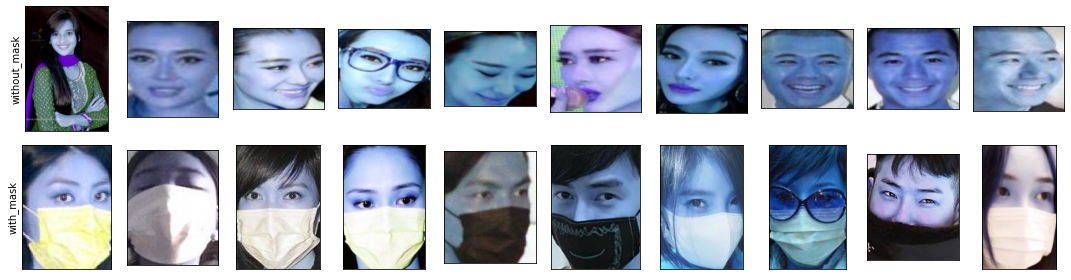

In [3]:
plt.figure(figsize=(15,4))
i=0
for c in CATEGORIES:  
    path = os.path.join(DIRECTORY,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(2,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()        
plt.show() 

In [4]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    'dataset/with_mask'
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        'dataset/with_mask/img1.jpg'
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

 66%|███████████████████████████████████████████████████▋                          | 1269/1915 [00:18<00:24, 26.83it/s]C:\Users\User\anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████| 1915/1915 [00:42<00:00, 45.00it/s]


In [5]:
# convert text to Binary
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


data = np.array(data, dtype="float32")
labels = np.array(labels)
print(data,labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

[[[[-0.94509804 -0.9764706  -0.85882354]
   [-0.94509804 -0.9764706  -0.85882354]
   [-0.94509804 -0.9764706  -0.85882354]
   ...
   [-0.8509804  -0.90588236 -0.78039217]
   [-0.8509804  -0.90588236 -0.78039217]
   [-0.84313726 -0.8980392  -0.77254903]]

  [[-0.9137255  -0.94509804 -0.827451  ]
   [-0.9137255  -0.94509804 -0.827451  ]
   [-0.9137255  -0.94509804 -0.827451  ]
   ...
   [-0.7647059  -0.79607844 -0.6784314 ]
   [-0.7647059  -0.79607844 -0.6784314 ]
   [-0.75686276 -0.7882353  -0.67058825]]

  [[-0.92156863 -0.9607843  -0.8039216 ]
   [-0.92156863 -0.9607843  -0.8039216 ]
   [-0.92156863 -0.9607843  -0.8039216 ]
   ...
   [-0.88235295 -0.8980392  -0.7882353 ]
   [-0.8666667  -0.88235295 -0.77254903]
   [-0.85882354 -0.8745098  -0.7647059 ]]

  ...

  [[ 0.3803922  -0.9607843  -0.36470586]
   [ 0.38823533 -0.9607843  -0.3960784 ]
   [ 0.3803922  -0.9607843  -0.42745095]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         

In [6]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [7]:
# load the MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [8]:
# Create head and the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [9]:
# Call head and the base model
model = Model(inputs=baseModel.input, outputs=headModel)

In [10]:
# loop over all layers in the base model and freeze them
for layer in baseModel.layers:
    layer.trainable = False

In [11]:
# compile our model 17
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=["accuracy"]
)

In [12]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=10)
# H = model.fit(x=trainX, y=trainY, epochs=5, batch_size=32)

Epoch 1/10
95/95 [==============================] - 209s 2s/step - loss: 0.1400 - accuracy: 0.9512 - val_loss: 0.0370 - val_accuracy: 0.9896
Epoch 2/10
95/95 [==============================] - 171s 2s/step - loss: 0.0573 - accuracy: 0.9825 - val_loss: 0.0960 - val_accuracy: 0.9648
Epoch 3/10
95/95 [==============================] - 194s 2s/step - loss: 0.0443 - accuracy: 0.9895 - val_loss: 0.0319 - val_accuracy: 0.9935
Epoch 4/10
95/95 [==============================] - 173s 2s/step - loss: 0.0332 - accuracy: 0.9878 - val_loss: 0.0422 - val_accuracy: 0.9870
Epoch 5/10
95/95 [==============================] - 187s 2s/step - loss: 0.0276 - accuracy: 0.9914 - val_loss: 0.0274 - val_accuracy: 0.9948
Epoch 6/10
95/95 [==============================] - 175s 2s/step - loss: 0.0347 - accuracy: 0.9881 - val_loss: 0.0337 - val_accuracy: 0.9896
Epoch 7/10
95/95 [==============================] - 181s 2s/step - loss: 0.0224 - accuracy: 0.9931 - val_loss: 0.0281 - val_accuracy: 0.9935
Epoch 8/10
95

In [13]:
# make predictions on the testing set
model.predict(testX, batch_size=BS)

24/24 [==============================] - 26s 965ms/step


array([[1.0000000e+00, 4.1323493e-15],
       [1.0000000e+00, 6.4738789e-14],
       [9.6967679e-01, 3.0323170e-02],
       ...,
       [1.8745606e-11, 1.0000000e+00],
       [9.9998045e-01, 1.9571264e-05],
       [5.4210950e-08, 1.0000000e+00]], dtype=float32)

In [15]:
# serialize the model to disk
model.save("mask_detector2.model", save_format="h5")